In [1]:
## Importing libraries
import time
import warnings

import eli5

warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")
%matplotlib inline


import optuna
from optuna.integration import LightGBMPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)

import plotly.express as px
from catboost import CatBoostRegressor, Pool
from lightgbm import DaskLGBMRegressor, LGBMRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    RobustScaler,
)
from xgboost import DMatrix, XGBRegressor

SEED = 42
import random

pd.set_option("display.max_columns", 679)
random.seed(SEED)

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Reading the data

In [2]:
train = pd.read_csv("Train.csv")

test = pd.read_csv("Test.csv")
sub = pd.read_csv("SampleSubmission (1).csv")
vard = pd.read_csv("VariableDescription.csv")

In [3]:
train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_except

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8585 entries, 0 to 8584
Columns: 679 entries, child_id to target
dtypes: float64(160), object(519)
memory usage: 44.5+ MB


In [5]:
df_train = train.copy()
df_test = test.copy()

# Encdoing categorical variable

In [6]:
# Here I am going to use LabelEncoder for certain columns and map with other columns.
le = LabelEncoder()

In [7]:
# train.columns[train.columns.str.contains("observe")].to_list()
observe_columns = [
    "child_observe_attentive",
    "child_observe_concentrated",
    "child_observe_diligent",
    "child_observe_interested",
]

mapper_observe = {"Sometimes": 1, "Almost never": 0, "Often": 2, "Almost always": 3}

In [8]:
social_columns = [
    "teacher_social_initiative",
    "teacher_social_peers",
    "teacher_social_nonaggressive",
    "teacher_social_cooperate",
    "teacher_social_assistance",
    "teacher_social_ideas",
    "teacher_social_initiative",
]

mapper_social = {
    "None of the time": 0,
    "A little of the time": 1,
    "Most of the time": 2,
    "All of the time": 3,
}

In [9]:
# Function to map values to the columns
def mapper(df, map_columns, map_values):
    for col in map_columns:
        df[col] = df[col].map(map_values)
    return df

In [10]:
# Mapping values
df_train = mapper(df_train, observe_columns, mapper_observe)
df_test = mapper(df_test, observe_columns, mapper_observe)

df_train = mapper(df_train, social_columns, mapper_social)
df_test = mapper(df_test, social_columns, mapper_social)

## Adding features 

In [11]:
df_train["child_gender"] = df_train["child_gender"].map({"male": 1, "female": 0})
df_test["child_gender"] = df_test["child_gender"].map({"male": 1, "female": 0})

In [12]:
df_train["pre_covid"] = le.fit_transform(df_train["pre_covid"])
df_test["pre_covid"] = le.fit_transform(df_test["pre_covid"])

In [13]:
df_train["language_child"] = le.fit_transform(df_train["language_child"])
df_test["language_child"] = le.fit_transform(df_test["language_child"])

In [14]:
## =========> END===========>

In [15]:
df_train.columns[df_train.columns.str.contains("child")]

Index(['child_id', 'child_date', 'child_age', 'child_enrolment_date',
       'child_months_enrolment', 'child_grant', 'child_years_in_programme',
       'child_height', 'child_observe_attentive', 'child_observe_concentrated',
       'child_observe_diligent', 'child_observe_interested',
       'child_observe_total', 'child_gender', 'child_dob', 'child_zha',
       'child_stunted', 'child_attends', 'child_attendance', 'child_languages',
       'child_age_group', 'pri_children_4_6_years', 'obs_toilets_children',
       'count_children_present', 'count_children_attendance',
       'count_children_precovid', 'count_toilets_children', 'language_child'],
      dtype='object')

In [16]:
# map_years = {'1st year in the programme': 1,
#              '2nd year in programme': 2,
#              '3rd year in programme': 3,
#              'Do Not Know':0}

# df_train["child_years_in_programme"] = df_train["child_years_in_programme"].map(map_years)
# df_test["child_years_in_programme"] = df_test["child_years_in_programme"].map(map_years)

In [17]:
df_train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_except

In [18]:
drop_cols = [
    "count_staff_gender_other",
    "pri_days",
    "obs_lighting_8",
    "count_practitioners_all",
    "count_register_gender_other",
    "obs_heating_3",
    "obs_lighting_5",
    "pri_difficult_see",
    "pri_difficult_walk",
    "obs_lighting_6",
    "teacher_social_initiative",
]
df_train[drop_cols].isnull().sum()

count_staff_gender_other       3424
pri_days                       3394
obs_lighting_8                 6330
count_practitioners_all        6957
count_register_gender_other    3470
obs_heating_3                  6324
obs_lighting_5                 6330
pri_difficult_see              6957
pri_difficult_walk             6957
obs_lighting_6                 6330
teacher_social_initiative      8585
dtype: int64

In [19]:
len(df_train.query("child_gender == 'Female'"))

0

In [20]:
# df_train["child_gender"] = df_child["child_gender"].map({"Male": })

In [21]:
# pd.set_option("display.max_rows", 50)
# df_train["child_dob"] =
# df_train["child_dob"] = pd.to_datetime(df_train["child_dob"],yearfirst=True)
# df_test["child_dob"] = pd.to_datetime(df_test["child_dob"],yearfirst=True)

# df_train["child_dob_month"] = df_train["child_dob"].dt.month
# df_test["child_dob_month"] = df_test["child_dob"].dt.month

# Machine Learning Algorithms

## Training with numerical columns only

In [22]:
n_splits = 10

kf = KFold(n_splits, shuffle=True, random_state=42)
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=42)

In [23]:
# # Cross validation
def cross_validation(X, y, model, cv_method):
    rmse_scores = list()

    # cv = cv_method(n_splits = N_SPLITS, n_repeats=5, random_state=1121218)

    for idx, (train_idx, test_idx) in enumerate(cv_method.split(X, y)):

        print("=" * 12 + f"Training fold {idx}" + 12 * "=")
        start = time.time()

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Making eval_set
        eval_set = [(X_test.values, y_test)]

        # Fitting the model to the data
        model.fit(X_train.values, y_train)

        # Predictions
        preds = model.predict(X_test)

        # Loss
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_scores.append(rmse)

        runtime = time.time() - start

        print(f"Fold {idx} finished with score: {rmse:.5f} in {runtime:.2f} seconds.\n")

    print(f"Average score {np.mean(rmse_scores)}")

    return np.mean(rmse_scores), rmse_scores


# rmse, cv_scores = cross_validation(X, y, hgbr, k_fold)

In [24]:
# Getting feature importances
def get_feature_imp(model, imp_factor):
    cols_imp = [
        (col, imp)
        for col, imp in zip(model.feature_name_, model.feature_importances_)
        if imp < imp_factor
    ]
    cols = [
        col
        for col, imp in zip(model.feature_name_, model.feature_importances_)
        if imp < imp_factor
    ]

    return cols, cols_imp

In [25]:
def feature_imp_dataframe(model):
    feature_imp = model.feature_importances_
    columns = model.feature_name_

    df_imp = pd.DataFrame({"features": columns, "feature_importance": feature_imp})

    df_imp.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    df_imp.reset_index(drop=True, inplace=True)

    return df_imp

In [26]:
def plot_feature_importance(df_feature_imp, n_imp_cols):
    labels = df_feature_imp.iloc[:30, 0].values

    plt.figure(figsize=(20, 6))
    ax = df_feature_imp.iloc[:30, 1].plot(kind="bar", title="Feature Importance")
    ax.set_xticklabels(labels)
    plt.show()

### Selecting numerical columns from df_train and df_test

### Lightgbm

In [27]:
cols_list_2 = [
    "pri_difficult_see",
    "count_staff_contract_substitute",
    "pri_difficult_walk",
    "obs_lighting_4",
    "obs_heating_3",
    "count_register_gender_other",
    "count_staff_paid_managers",
    "obs_lighting_5",
    "count_practitioners_all",
    "obs_cooking_4",
    "pri_days",
    "count_staff_gender_other",
    "obs_cooking_5",
    "obs_lighting_6",
    "obs_lighting_3",
]

cols_list_3 = [
    "pri_difficult_see",
    "count_staff_contract_substitute",
    "pri_difficult_walk",
    "obs_lighting_4",
    "obs_heating_3",
    "count_register_gender_other",
    "count_staff_paid_managers",
    "obs_lighting_5",
    "count_practitioners_all",
    "obs_cooking_4",
    "pri_days",
    "count_staff_gender_other",
    "obs_cooking_5",
    "obs_lighting_6",
    "obs_lighting_3",
    "language_match",
    "teacher_social_initiative",
    "obs_lighting_8",
    "obs_heating_7",
]

In [28]:
train_int_cols = df_train.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns
test_int_cols = df_test.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns

# Numerical columns
num_cols = list(set(test_int_cols).intersection(set(train_int_cols)))


X, y = df_train[num_cols].drop(columns=drop_cols), df_train[["target"]]
# X, y = df_train[num_cols].drop(columns=cols_list_2), df_train[['target']]
# X, y = df_train[num_cols].drop(columns=cols_list_3), df_train[['target']]

# Selecting the features for test-data
# Prediction on test set
test_data = df_test[X.columns.to_list()]

In [29]:
X.shape, y.shape

((8585, 161), (8585, 1))

In [30]:
X.head()

,count_register_gender_male,child_observe_diligent,count_staff_paid_maintenance,pra_class_attendance_precovid,pra_class_space,pri_expense_rent,obs_cooking_3,pra_measure_rectangle_width,pqa_class_assistants,count_register_all,count_register_year_2013,pri_capacity,teacher_social_peers,teacher_social_nonaggressive,obs_lighting_1,pra_experience,obs_cooking_2,count_present_girls,pri_difficult_hear,pri_fees_amount_2_3,obs_heating_6,count_register_race_indian,obs_cooking_1,count_staff_qual_nqf4_5,child_observe_attentive,pri_expense_materials,count_staff_time_part,count_practitioners_age_4,pqa_score_environment,count_practitioners_age_6,count_staff_salary_paid,pri_amount_funding_dsd,count_staff_gender,quintile,pri_time_open_minutes,count_register_race_white,id_mn_n,count_staff_paid_support,pri_time_close_minutes,id_facility,id_ward,id_ward_n,obs_lighting_2,obs_cooking_6,count_staff_qual_nqf6_9,child_months_enrolment,longitude,pri_difficult_hold,count_present_boys,latitude,count_staff_contract_temporary,count_staff_salary_unpaid,pra_class_attendance,count_children_present,count_staff_gender_female,count_staff_paid,pri_difficult_learn,teacher_duration,count_staff_contract_permanent,child_gender,id_team,count_register_gender_female,count_practitioners_age_2,teacher_social_cooperate,count_staff_gender_male,count_staff_paid_managers,count_register_foreign,id_prov_n,pri_dsd_year,pqa_score_curriculum,obs_heating_1,pri_year,id_dc_n,child_observe_interested,count_register_year_school,count_staff_salary,count_register_year_2015,count_staff_time,count_toilets_adults,count_register_race_african,language_match,child_age,pri_clinic_time,count_practitioners_age_1,count_staff_time_full,pra_class_present,teacher_social_ideas,teacher_social_assistance,count_register_year_2019,count_practitioners_age_5,sanitation_educators,obs_heating_2,count_register_year_2021,count_staff_paid_practitioners,count_register_race_other,count_practitioners_age_3,obs_heating_5,pri_expense_maintenance,pra_hhsize,count_register_year_2018,child_observe_total,pri_fees_amount_4_6,obs_classrooms,child_observe_concentrated,count_staff_contract,id_enumerator,pri_amount_funding_fees,count_toilets_children,child_zha,count_register_year_2020,pri_fees_amount_0_1,pri_fees_amount_pv,pri_difficult_communicate,teacher_social_total,pri_expense_staff,count_register_gender,count_register_race,id_facility_n,teacher_selfcare_total,pri_time_open_hours,obs_lighting_4,pri_time_close_hours,language_child,count_practitioners_age_0,pqa_score_teaching,count_staff_contract_substitute,count_staff_paid_cooks,pri_covid_staff_retrench,count_register_year_grader,count_children_precovid,obs_cooking_4,pri_fees_amount,obs_heating_4,data_year,pqa_score_assessment,obs_cooking_5,child_height,pri_expense_admin,pri_funding_subsidy,ses_proxy,child_attendance,pra_measure_rectangle_length,count_staff_qual_skills,count_staff_paid_assistants,count_children_attendance,count_register_year_2014,count_register_race_coloured,teacher_emotional_total,count_register_year_2016,opening_hours,pre_covid,count_staff_all,pri_children_4_6_years,pri_expense_other,pri_expense_food,obs_lighting_3,pqa_score_relationships,obs_heating_7,count_register_year_2017,pra_class_size,ward_best
0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,107.0,NaN,NaN,761.0,74201039.0,14.0,NaN,NaN,NaN,NaN,27.879824,NaN,NaN,-26.551048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1051.0,NaN,NaN,NaN,NaN,134.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,59.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1,NaN,20005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Capturing NaN per row and making a new feature

In [31]:
def feature_engineering(df):
    df["NaN_row"] = df.isna().sum(axis=1)
    df["std"] = df.std(axis=1)
    return df


X = feature_engineering(X)
test_data = feature_engineering(test_data)

# Filling missing values

In [32]:
# pipeline = Pipeline(
#     [
#         ("impute", SimpleImputer()),
#         ("scale", MinMaxScaler())
#         # ('quantiletransform', QuantileTransformer(random_state=seed))
#     ]
# )

# X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
# test_data = pd.DataFrame(columns=test_data.columns, data=pipeline.transform(test_data))

In [33]:
X.shape, test_data.shape

((8585, 163), (3680, 163))

In [34]:
(X.var()[:-50])

count_register_gender_male          364.908514
child_observe_diligent                0.848987
count_staff_paid_maintenance          0.372254
pra_class_attendance_precovid       146.258774
pra_class_space                     667.004868
                                     ...      
child_zha                             1.205852
count_register_year_2020             16.626163
pri_fees_amount_0_1              236816.884282
pri_fees_amount_pv               241920.431286
pri_difficult_communicate             1.900150
Length: 113, dtype: float64

In [35]:
params = {
    "learning_rate": 0.01,
    "objective": "poisson",
    # "objective": "tweedie",
    "n_estimators": 5500,
    "num_leaves": 35,
    "max_bin": 240,
    "colsample_bytree": 0.3,
    # "max_depth": 9,
    "min_child_samples": 20,
}

In [36]:
best_trial = {
    "n_estimators": 54884,
    "reg_alpha": 1.511619688143909,
    "reg_lambda": 0.46134859372486536,
    "colsample_bytree": 0.3,
    "subsample": 1.0,
    "learning_rate": 0.02,
    "max_depth": 20,
    "num_leaves": 16,
    "min_child_samples": 21,
    "min_data_per_groups": 48,
}

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=55
)

# Training the model with reduced columns
lgbm = LGBMRegressor(**params)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    early_stopping_rounds=200,
    verbose=False,
)

# Get score
lgbm.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 9.489886034600657),
                          ('poisson', -140.75056679790933)])})

In [38]:
get_feature_imp(lgbm, 5)

(['child_gender', 'count_staff_contract_substitute', 'obs_heating_7'],
 [('child_gender', 0),
  ('count_staff_contract_substitute', 2),
  ('obs_heating_7', 3)])

In [39]:
# Training the model on whole dataset
lgbm = LGBMRegressor(**params)
lgbm.fit(X, y)

LGBMRegressor(colsample_bytree=0.3, learning_rate=0.01, max_bin=240,
              n_estimators=5500, num_leaves=35, objective='poisson')

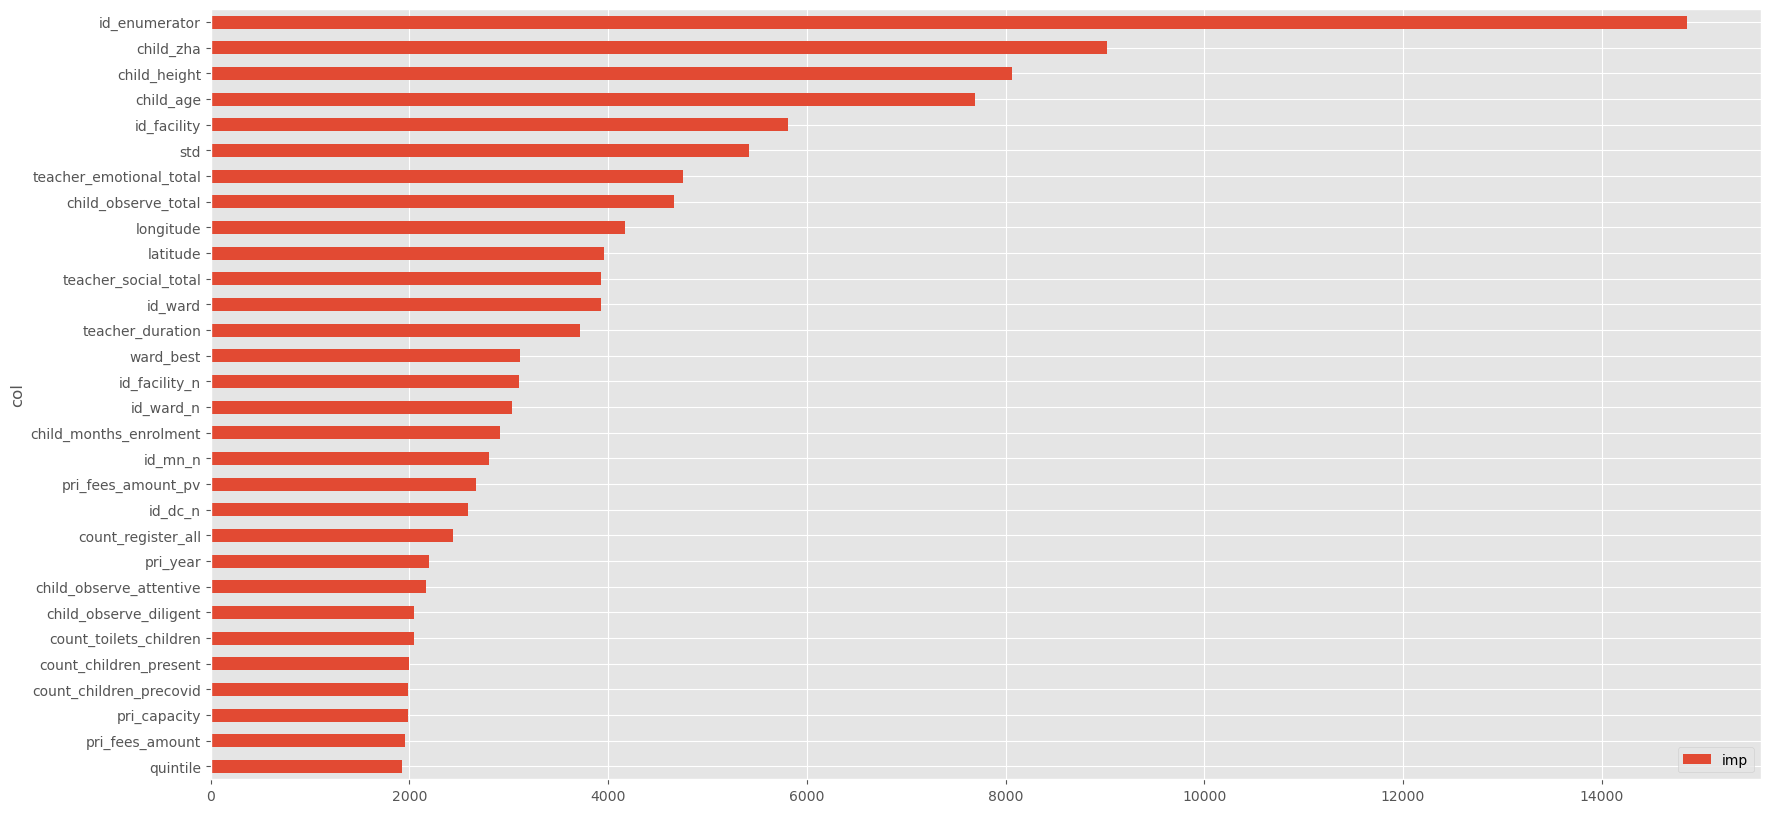

In [40]:
fea_imp = pd.DataFrame({"imp": lgbm.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=True).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")

In [41]:
# Prediction on test set
# test_data = df_test[X.columns.to_list()]

preds = lgbm.predict(test_data)
preds

array([60.78395638, 46.67618443, 48.22171929, ..., 39.97751668,
       41.58497672, 44.72691541])

In [42]:
# Creating a submissionfile
sub_file = pd.read_csv("GBRSubmission1_score_10.63.csv")
sub_file.target = preds
sub_file.to_csv("LGBMSubmission_drop_cols_4.csv", index=False)

In [43]:
kjkjkd

NameError: name 'kjkjkd' is not defined

In [ ]:
import optuna
from sklearn.model_selection import train_test_split


def objective(trial, data=X, target=y):

    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=0.2, random_state=42
    )
    param = {
        "metric": "rmse",
        "random_state": 42,
        # "n_estimators": 20000,
        "n_estimators": trial.suggest_int("n_estimators", 100, 100_000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.001, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04, 0.05]
        ),
        "max_depth": trial.suggest_categorical(
            "max_depth",
            [
                6,
                7,
                8,
                8,
                10,
                11,
                13,
                14,
                15,
                20,
            ],
        ),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("min_data_per_groups", 1, 100),
    }
    model = LGBMRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds, squared=False)

    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)